**TODO:**  log return plots

## Investigate free data sets at their providers' pages

1. Based on the descriptions at the provider pages, explain what each data set means.
2. Select two data sets, and compare their changes at times when something happened in the world.
3. Note: the word "spread" means difference.

| Source | Name, Link to page | Type | Further information |
| :--- | :--| :--- | :-- |
|[Yahoo Finance](https://finance.yahoo.com) | [S&P500 stock market index](https://finance.yahoo.com/quote/%5EGSPC/history) | Equity index |  Large cap stocks |
| &nbsp; | [Walmart stock price](https://finance.yahoo.com/quote/WMT/history) | Equity | Retail, Big capitalization |
| &nbsp; | [Amazon](https://finance.yahoo.com/quote/AMZN/history) | Equity | IT, Big cap |
| &nbsp; | [Tesla](https://finance.yahoo.com/quote/TSLA/history) | Equity | Tech / Cars |
| &nbsp; | [BJ's Restaurants](https://finance.yahoo.com/quote/BJRI/history) | Equity | Catering industry, Small cap |
| &nbsp; | [Bitcoin](https://finance.yahoo.com/quote/BTC-USD/history) | FX |  Payments / Investment | 
| &nbsp; | [Ethereum](https://finance.yahoo.com/quote/ETH-USD/history) | FX | also infrastructural | 
|[FRED](https://fred.stlouisfed.org) | Employment: [Not seasonally adjusted](https://fred.stlouisfed.org/series/PAYNSA)<br/>and [Seasonally adjusted](https://fred.stlouisfed.org/series/PAYEMS) | Macroeconomy | Total non-farm employees |
| &nbsp; | [USD 1Y swap rate ICE (3pm daily)](https://fred.stlouisfed.org/series/ICERATES1500USD1Y) | Rates | [ICE methodology](https://www.theice.com/publicdocs/ICE_Swap_Rate_Full_Calculation_Methodology.pdf) |
| &nbsp; | [Ounce of gold in USD](https://fred.stlouisfed.org/series/GOLDPMGBD228NLBM) | Commodity | Gold: bullion |
| &nbsp; | [Moody's AAA 10Y credit spread](https://fred.stlouisfed.org/series/AAA10Y) | Bonds vs 10Y Treasury  | Spread to 10Y T-bond |
| &nbsp; | [YEN / USD exchange rate](https://fred.stlouisfed.org/series/DEXJPUS) | FX | &nbsp; | 
| &nbsp; | [Wilshire US Real Estate Securities Price Index](https://fred.stlouisfed.org/series/WILLRESIPR)  | Real estate index | [Wilshire's description](https://www.wilshire.com/indexes/wilshire-real-estate-family/wilshire-us-resi) |
|[ECB](https://sdw.ecb.europa.eu) | [USD / EUR exchange rate](https://sdw.ecb.europa.eu/quickview.do?SERIES_KEY=120.EXR.D.USD.EUR.SP00.A) | FX | ECB reference rate |
|[Bp Stock Exch](https://bse.hu/pages/data-download) | OTP | Equity | Banking, Regional |
| &nbsp; | Richter | Equity | Pharma |
| &nbsp; | Telekom HU | Equity | subsidiary of Deutsche Telekom |

## Investigate the data locally

### Download the data files
For each row in the above list of data sets, please click the link pointing to the download page of the given data set,<br/>
and then download the data file to the `data` subfolder of your current directory.

$(1a)\,\,$ On the (historical data) download page of a Yahoo data set, select "Max" Time Period, click Apply, and then click "Download".
<br/>
$(1b)\,\,$ The S&P500 data set does not have the "Download" button.
Download the entire html file, and process it with the script below.

$(2)\,\,$ On the download page of a FRED data set, click "Download" in the top right corner, and select "CSV".

$(3)\,\,$ When downloading the EUR/USD data from the ECB, click "Data Download" (top right), select "Excel (csv)",<br/>
and save the file with this name: `120.EXR.D.USD.EUR.SP00.A.csv`. You may need to add the .csv extension manually. 

$(4)\,\,$ To download data from the Budapest Stock Exchange, do the following at https://bse.hu/pages/data-download:<br/>

$\,\,\,\,$<i>Settings</i><br/>

    . Time range: From day to day
    . From day to day: 2017-01-01 to 2021-12-31
    . Data format: Comma separated (.csv)
    . Data type: Detailed (values, averages, volumes)

$\,\,\,\,$<i>Under "Primary Market" select</i><br/>

    . Category: Equities Prime
    . Instrument: OTP

$\,\,\,\,$<i>Click "Download"</i><br/>

    . Save the downloaded file with the name **OTP.csv** to the data subfolder of your current directory
    . Similarly download into **separate** files the data for RICHTER and MTELEKOM

### Convert the SP500 data set

Convert the downloaded html to csv

$(1)\,\,$ Go to https://finance.yahoo.com/quote/%5EGSPC/history , and scroll down to the bottom to force loading all lines.

$(2)\,\,$ Save as `html only` the entire html page as `SP500.html` below the `data` subfolder of your current folder.

$(3)\,\,$ Run the below script to extract data from `SP500.html` and save it to `SP500.csv`.  

In [150]:
import re
from os.path import join, isfile, getsize
import datetime
import json
from collections import OrderedDict
from logging import getLogger

logger = getLogger('conversion')

DAT = {
    'infile': join('data', 'SP500.html'),
    'outfile': join('data', 'SP500.csv'),
    'columns': OrderedDict([  # ordered list of column names converted from data field names
        ('date', 'Date'),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('adjclose', 'Adj Close'),
        ('volume', 'Volume')
    ])
}


def yahoo_index_convert_from_html_to_csv(dat=None):

    """
    Read yahoo html page of S&P 500 data
    Write index to csv file
    """

    if isfile(dat['outfile']) and getsize(dat['outfile']) > 0:
        return f'Conversion is skipped because a non-empty {dat["outfile"]} is already present'
    else:
        # read the input file and extract the string formatted (json dumped) list of price data records
        html = open(dat['infile']).read()
        m = re.search(r'("prices":\[(.+?)\])', html)
        if m:
            prices_str = m.group(1)  # all price information in string format
            output_header = ','.join(dat['columns'].values())
            output_data_lines = []

            # convert input data records one by one
            for price_info in re.findall(r'({.+?})', prices_str):
                info = json.loads(price_info)  # price information (the current record) in dictionary format
                line = ''

                # save the first data column: the date of the record
                if 'date' in info:
                    this_date = datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=info['date'])
                    line += (str(this_date.year) + '-' + str(this_date.month).zfill(2) + '-' + 
                             str(this_date.day).zfill(2))
                else:
                    raise ValueError(f'No date in this price info record: {price_info}')

                # save the other data columns of the record
                other_columns = list(dat['columns'].keys())[1:]
                for column in other_columns:
                    line += ','
                    if column in info:
                        line += str(info[column])

                # save the data line
                output_data_lines.append(line)

        # write output to csv file
        with open(dat['outfile'], 'w') as f:
            f.write('\n'.join([output_header] + output_data_lines))

        return f'Conversion completed: {dat["infile"]} -> {dat["outfile"]}'

    
result = yahoo_index_convert_from_html_to_csv(dat=DAT)
print(result)

Conversion is skipped because a non-empty data\SP500.csv is already present


### Read data. Display summaries.

In [3]:
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import os
data_dir = 'data'
file_ext = 'csv'
df = {}  # data frames by data set code

# Time series from: Yahoo Finance, Federal Reserve Economic Data, European Central Bank, Portfolio.hu
yahoo_codes = ['WMT','AMZN','TSLA','BJRI','BTC-USD','ETH-USD']
fred_codes = ['PAYEMS','PAYNSA','SP500','AAA10Y','DEXJPUS','GOLDPMGBD228NLBM','ICERATES1500USD1Y','SP500','WILLRESIPR']
ecb_codes = ['120.EXR.D.USD.EUR.SP00.A']
bse_codes = ['MTELEKOM','OTP','RICHTER']
all_codes = yahoo_codes + fred_codes + ecb_codes + bse_codes

# Investigate each data frame
for code in all_codes:
    skiprows = [0, 1, 2, 3, 4] if code.startswith('120.EXR.D') else None
    df[code] = pd.read_csv(os.path.join(data_dir, code + '.' + file_ext), skiprows=skiprows)
    display(code, df[code].describe())  # display description

'WMT'

,Open,High,Low,Close,Adj Close,Volume
count,12446.000000,12446.000000,12446.000000,12446.000000,12446.000000,1.244600e+04
mean,35.103571,35.431593,34.778999,35.109349,28.549015,7.536033e+06
std,36.744552,37.050351,36.456288,36.750815,34.001272,6.246291e+06
min,0.015625,0.015625,0.014404,0.015625,0.008889,0.000000e+00
25%,1.379883,1.391601,1.363281,1.378906,0.853487,3.875800e+06
50%,16.062500,16.156250,15.937500,16.093750,10.387841,6.300900e+06
75%,56.099998,56.777499,55.480000,56.070000,40.774788,9.509950e+06
max,153.600006,153.660004,151.660004,152.789993,150.842651,1.318336e+08


'AMZN'

,Open,High,Low,Close,Adj Close,Volume
count,6200.000000,6200.000000,6200.000000,6200.000000,6200.000000,6.200000e+03
mean,541.934611,547.885860,535.393106,541.791999,541.791999,7.300651e+06
std,889.934336,899.173216,879.611533,889.402988,889.402988,7.131791e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,38.864999,39.610001,38.230000,38.937499,38.937499,3.557250e+06
50%,94.895001,95.974998,92.830002,94.360001,94.360001,5.446200e+06
75%,551.880020,559.630005,543.587479,552.625016,552.625016,8.262375e+06
max,3744.000000,3773.080078,3696.790039,3731.409912,3731.409912,1.043292e+08


'TSLA'

,Open,High,Low,Close,Adj Close,Volume
count,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2.899000e+03
mean,123.262719,125.882152,120.492565,123.360381,123.360381,3.139069e+07
std,226.272890,231.207664,220.999259,226.491649,226.491649,2.823235e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,17.118000,18.094999,16.420001,17.483000,17.483000,1.284450e+07
50%,46.144001,46.956001,45.422001,46.122002,46.122002,2.482750e+07
75%,66.691002,67.971001,65.465000,66.784000,66.784000,3.999685e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


'BJRI'

,Open,High,Low,Close,Adj Close,Volume
count,6351.000000,6351.000000,6351.000000,6351.000000,6351.000000,6.351000e+03
mean,24.308636,24.722775,23.880987,24.300893,23.769456,2.426567e+05
std,17.365067,17.606406,17.102463,17.348653,17.026700,2.671375e+05
min,0.937500,1.187500,0.812500,1.000000,0.973013,0.000000e+00
25%,7.790000,8.050000,7.520000,7.780000,7.570039,5.200000e+04
50%,21.549999,21.950001,21.150000,21.530001,20.990000,1.931000e+05
75%,38.514999,39.099998,37.965000,38.529999,37.709105,3.399500e+05
max,76.099998,76.500000,75.050003,75.699997,74.381866,5.316700e+06


'BTC-USD'

,Open,High,Low,Close,Adj Close,Volume
count,1516.000000,1516.000000,1516.000000,1516.000000,1516.000000,1.516000e+03
mean,18177.501195,18674.586001,17629.543329,18200.627982,18200.627982,2.519144e+10
std,17511.897832,17995.602505,16956.622318,17519.746374,17519.746374,2.100397e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2.923670e+09
25%,7184.975952,7323.174805,6939.701782,7186.172241,7186.172241,7.729972e+09
50%,9522.534668,9699.287597,9309.574219,9524.172363,9524.172363,2.120531e+10
75%,22888.313965,23773.729004,22407.510742,23163.807129,23163.807129,3.579627e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


'ETH-USD'

,Open,High,Low,Close,Adj Close,Volume
count,1516.000000,1516.000000,1516.000000,1516.000000,1516.000000,1.516000e+03
mean,924.927941,957.785595,888.389839,926.914547,926.914547,1.231580e+10
std,1179.910915,1219.637767,1135.029719,1181.381377,1181.381377,1.145672e+10
min,84.279694,85.342743,82.829887,84.308296,84.308296,6.217330e+08
25%,189.072636,194.386757,184.895260,189.247181,189.247181,2.896238e+09
50%,360.310578,372.303497,352.717926,362.620102,362.620102,8.896970e+09
75%,1055.449982,1130.613220,995.162506,1055.385040,1055.385040,1.789345e+10
max,4810.071289,4891.704590,4718.039063,4812.087402,4812.087402,8.448291e+10


'PAYEMS'

,PAYEMS
count,995.000000
mean,90311.106533
std,36948.547559
min,29923.000000
25%,53592.000000
50%,89865.000000
75%,130305.500000
max,152523.000000


'PAYNSA'

,PAYNSA
count,995.000000
mean,90311.482412
std,36960.958946
min,29296.000000
25%,53486.500000
50%,89631.000000
75%,130117.000000
max,153095.000000


'SP500'

,Open,High,Low,Close,Adj Close,Volume
count,23614.000000,23614.000000,23614.000000,23614.000000,23614.000000,2.361400e+04
mean,512.066377,535.502008,529.155040,532.542114,532.542114,8.082425e+08
std,841.554930,834.360352,825.412744,830.220336,830.220336,1.522272e+09
min,0.000000,4.400000,4.400000,4.400000,4.400000,0.000000e+00
25%,9.372500,24.150000,24.150000,24.150000,24.150000,1.350000e+06
50%,34.585001,101.155003,99.564999,100.320000,100.320000,1.810500e+07
75%,899.464981,910.000000,887.569977,900.697495,900.697495,6.536175e+08
max,4795.490234,4808.930176,4780.040039,4793.060059,4793.060059,1.145623e+10


'AAA10Y'

,DATE,AAA10Y
count,10173,10173
unique,10173,311
top,1983-01-03,.
freq,1,424


'DEXJPUS'

,DATE,DEXJPUS
count,13299,13299
unique,13299,7031
top,1971-01-04,.
freq,1,518


'GOLDPMGBD228NLBM'

,DATE,GOLDPMGBD228NLBM
count,14024,14024
unique,14024,7871
top,1968-04-01,.
freq,1,524


'ICERATES1500USD1Y'

,DATE,ICERATES1500USD1Y
count,1932,1932
unique,1932,1002
top,2014-08-01,.
freq,1,319


'SP500'

,Open,High,Low,Close,Adj Close,Volume
count,23614.000000,23614.000000,23614.000000,23614.000000,23614.000000,2.361400e+04
mean,512.066377,535.502008,529.155040,532.542114,532.542114,8.082425e+08
std,841.554930,834.360352,825.412744,830.220336,830.220336,1.522272e+09
min,0.000000,4.400000,4.400000,4.400000,4.400000,0.000000e+00
25%,9.372500,24.150000,24.150000,24.150000,24.150000,1.350000e+06
50%,34.585001,101.155003,99.564999,100.320000,100.320000,1.810500e+07
75%,899.464981,910.000000,887.569977,900.697495,900.697495,6.536175e+08
max,4795.490234,4808.930176,4780.040039,4793.060059,4793.060059,1.145623e+10


'WILLRESIPR'

,DATE,WILLRESIPR
count,6002,6002
unique,6002,4950
top,1998-12-31,.
freq,1,212


'120.EXR.D.USD.EUR.SP00.A'

,Unnamed: 0,Unnamed: 1,obs. status
count,5953,5953,5953
unique,5953,3592,2
top,2022-01-03,-,Normal value (A)
freq,1,62,5891


'MTELEKOM'

,Close price,Volume (piece),Volume (HUF value),Volume (EUR value),Number of trades,Open price,Minimum price,Maximum price,Average price,Capitalization
count,1243.000000,1.243000e+03,1.243000e+03,1.243000e+03,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03
mean,431.337490,6.431326e+05,2.833325e+08,8.719703e+05,319.025744,431.577635,428.395414,434.400644,431.343397,4.497740e+11
std,38.503045,6.343656e+05,2.986727e+08,9.544087e+05,209.952945,38.519306,38.793986,38.160859,38.516390,4.014876e+10
min,341.000000,2.980700e+04,1.190664e+07,3.412176e+04,41.000000,341.000000,335.000000,344.500000,340.595766,3.555752e+11
25%,404.000000,2.999585e+05,1.249556e+08,3.648007e+05,199.000000,405.000000,401.000000,408.000000,404.571151,4.212680e+11
50%,430.000000,4.801940e+05,2.082212e+08,6.311472e+05,278.000000,430.000000,426.000000,433.000000,430.040980,4.483793e+11
75%,463.500000,7.909310e+05,3.461085e+08,1.068366e+06,382.000000,464.250000,461.000000,467.000000,463.901945,4.833112e+11
max,525.000000,8.817938e+06,4.344597e+09,1.407932e+07,3176.000000,525.000000,521.000000,527.000000,524.286333,5.474398e+11


'OTP'

,Close price,Volume (piece),Volume (HUF value),Volume (EUR value),Number of trades,Open price,Minimum price,Maximum price,Average price,Capitalization
count,1243.000000,1.243000e+03,1.243000e+03,1.243000e+03,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03
mean,12002.386163,5.274898e+05,6.236810e+09,1.856123e+07,1950.148833,12001.008850,11870.238134,12124.032180,11999.594029,3.360668e+12
std,2617.163644,6.316243e+05,9.979964e+09,2.746193e+07,1217.149335,2616.493826,2593.073126,2640.634061,2616.555163,7.328058e+11
min,7815.000000,4.872000e+04,4.080223e+08,1.318753e+06,321.000000,7805.000000,7724.000000,7895.000000,7821.303263,2.188200e+12
25%,10100.000000,2.910240e+05,3.524743e+09,1.068574e+07,1196.500000,10117.500000,9997.500000,10220.000000,10110.387889,2.828000e+12
50%,11450.000000,4.112540e+05,4.890114e+09,1.463354e+07,1610.000000,11450.000000,11320.000000,11570.000000,11428.874826,3.206000e+12
75%,13405.000000,5.989115e+05,6.990029e+09,2.095818e+07,2319.500000,13397.500000,13270.000000,13565.000000,13417.192043,3.753400e+12
max,19400.000000,1.467124e+07,2.659743e+11,7.280185e+08,9411.000000,19155.000000,19070.000000,19590.000000,19210.399058,5.432000e+12


'RICHTER'

,Close price,Volume (piece),Volume (HUF value),Volume (EUR value),Number of trades,Open price,Minimum price,Maximum price,Average price,Capitalization
count,1243.000000,1.243000e+03,1.243000e+03,1.243000e+03,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1.243000e+03
mean,6562.119871,3.208007e+05,2.054812e+09,6.189403e+06,1069.463395,6561.482703,6490.902655,6629.995977,6560.646436,1.223014e+12
std,1181.254557,2.173259e+05,1.334413e+09,4.034491e+06,518.542660,1179.283694,1171.188985,1193.058828,1181.329405,2.201562e+11
min,4570.000000,3.925000e+04,2.351274e+08,7.251648e+05,254.000000,4578.000000,4468.000000,4718.000000,4587.739416,8.517331e+11
25%,5462.500000,1.806250e+05,1.195561e+09,3.590250e+06,725.500000,5462.500000,5387.500000,5522.500000,5458.690673,1.018073e+12
50%,6569.000000,2.663320e+05,1.726260e+09,5.251892e+06,960.000000,6575.000000,6505.000000,6636.000000,6574.118928,1.224296e+12
75%,7079.000000,3.934375e+05,2.518268e+09,7.563056e+06,1301.000000,7065.000000,7005.000000,7140.000000,7072.327682,1.319348e+12
max,9105.000000,2.143269e+06,1.231967e+10,3.947978e+07,5433.000000,9120.000000,9065.000000,9320.000000,9145.939903,1.696943e+12


### Plot Max / Median vs Mean / Median of the distribution of daily volume 

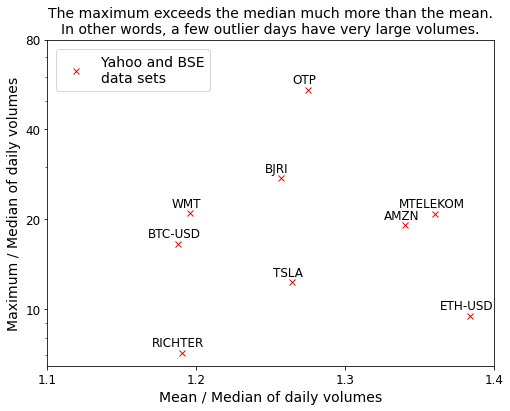

In [83]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict

DAT = {
    'yahoo_codes': yahoo_codes,
    'bse_codes': bse_codes,
    'fontsize': 14,
    'ticks_fontsize': 12,
    'label_fontsize': 12,
    'yticks': [10, 20, 40, 80],
    'xticks': [1.1, 1.2, 1.3, 1.4],
    'color': 'red',
    'marker': 'x',
    'markersize': 6
}


def get_mean_per_median_and_max_per_median(yahoo_codes=None, bse_codes=None):
    """
    Mean/Median and Max/Median ratio of the distribution of daily volumes for each data set
    """
    mean_per_median = OrderedDict()
    max_per_median = OrderedDict()

    for code in yahoo_codes:
        mean_per_median[code] = df[code]['Volume'].mean() / df[code]['Volume'].median()
        max_per_median[code] = df[code]['Volume'].max() / df[code]['Volume'].median()

    for code in bse_codes:
        mean_per_median[code] = df[code]['Volume (HUF value)'].mean() / df[code]['Volume (HUF value)'].median()
        max_per_median[code] = df[code]['Volume (HUF value)'].max() / df[code]['Volume (HUF value)'].median()

    return mean_per_median, max_per_median


def plot_max_per_median_vs_mean_per_median(dat=None):
    """
    For the selected data sets plot the max/median vs the mean/median of the daily volumes
    """
    mean_per_median, max_per_median = get_mean_per_median_and_max_per_median(
        yahoo_codes=dat['yahoo_codes'], bse_codes=dat['bse_codes'])

    for tick in ['xtick', 'ytick']:
        plt.rc(tick, labelsize=dat['ticks_fontsize'])

    plt.plot(mean_per_median.values(), max_per_median.values(), label='Yahoo and BSE\ndata sets',
             lw=0, c=dat['color'], marker=dat['marker'], markersize=dat['markersize'])
    plt.legend(bbox_to_anchor=(.02, .97), loc=2, borderaxespad=0., fontsize=dat['fontsize'])
    plt.title('The maximum exceeds the median much more than the mean.\n'
              'In other words, a few outlier days have very large volumes.', fontsize=dat['fontsize'])
    plt.xlabel('Mean / Median of daily volumes', fontsize=dat['fontsize'])
    plt.ylabel('Maximum / Median of daily volumes', fontsize=dat['fontsize'])
    plt.yscale('log')

    plt.xticks(dat['xticks'], [str(x) for x in dat['xticks']])
    plt.yticks(dat['yticks'], [str(y) for y in dat['yticks']])

    for x, y, label in zip(mean_per_median.values(), max_per_median.values(), mean_per_median.keys()):
        plt.annotate(label, (x, y), textcoords='offset points', xytext=(-4, 6), ha='center', 
                     fontsize=dat['label_fontsize'])

    fig = plt.gcf()
    fig.set_size_inches([8, 6])
    plt.show()

    


plot_max_per_median_vs_mean_per_median(dat=DAT)

## Plot value. Plot Daily and Monthly log return.

1. Noting that the vertical scale is logarithmic, which stocks have had long periods of exponential growth ?
2. In which year did WMT (Walmart) have bigger changes relative to itself: 1975 or 2005 ?

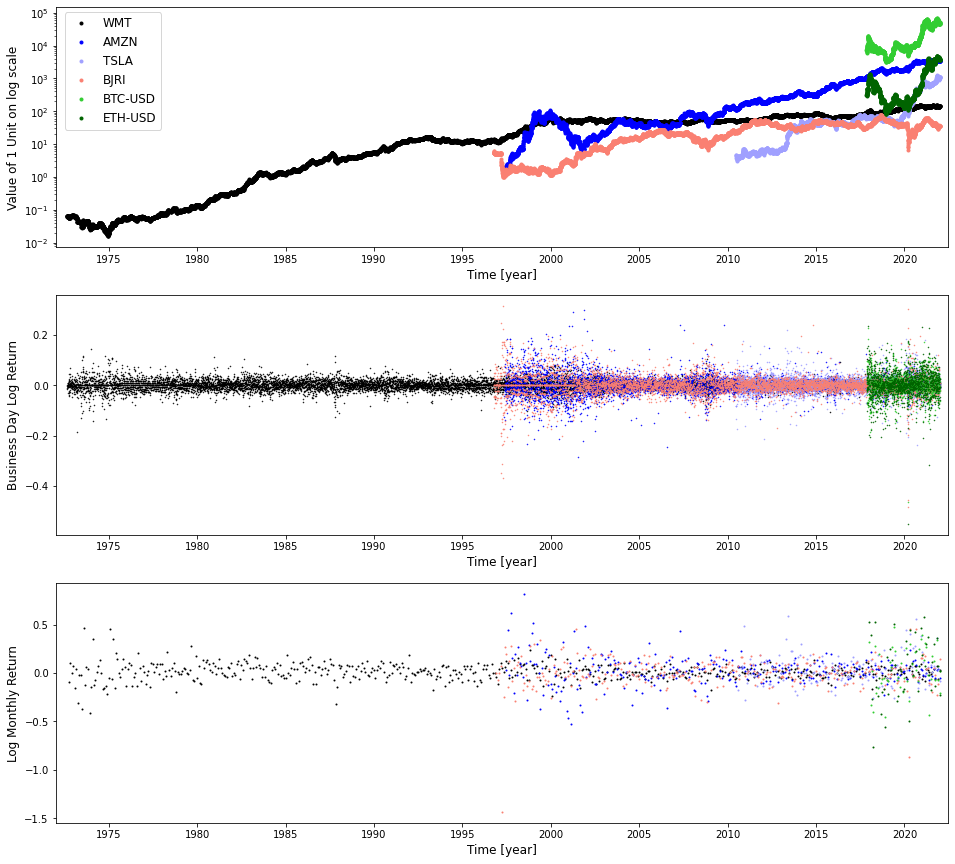

In [13]:
import matplotlib.pyplot as plt
import datetime
import numpy as np


def last_date_in_each_month(businessDays):
    '''Get last date in each month of a time series'''
    dateRange = []  
    tempYear = None  
    dictYears = businessDays.groupby(businessDays.year)
    for yr in dictYears.keys():
        tempYear = pd.DatetimeIndex(dictYears[yr]).groupby(pd.DatetimeIndex(dictYears[yr]).month)
        for m in tempYear.keys():
            dateRange.append(max(tempYear[m]))
    return dateRange


def prepare_data_and_plot_time_series():
    # set dataframe index to datetime
    for code in yahooCodes:
        df[code].index = pd.to_datetime( df[code]['Date'] )

    # create dataframe of monthly returns
    dfm = dict() # dict to save monthly close data by data set key
    for code in yahooCodes:    
        all_dates = df[code].index
        month_last_dates = last_date_in_each_month(all_dates)
        dfm[code] = pd.DataFrame(df[code], index=month_last_dates)

    # daily and monthly log return
    for code in yahooCodes:
        df[code]['LogReturn']  = np.log(df[code]['Close']) -  np.log(df[code]['Close'].shift())
        dfm[code]['LogReturn'] = np.log(dfm[code]['Close']) - np.log(dfm[code]['Close'].shift())

    # parameters for drawing
    xlims=[datetime.date(1972,1,1),datetime.date(2022,6,30)] # horizontal axis limits
    ylims=[-.45,.45]
    removeOutlierBelowMinusOne = True # whether we should remove the log daily return outlier
    yahooColors = ['black','blue','#a0a0ff','salmon','limegreen','darkgreen']
    fontsize=12
    marker='.'

    # plot daily values
    plt.subplot(311)
    for code,color in zip(yahooCodes,yahooColors):
        plt.plot(df[code]['Close'], c=color, marker=marker, label=code, lw=0)
    plt.legend(bbox_to_anchor=(0.01, .98), loc=2, borderaxespad=0., fontsize=fontsize)
    plt.yscale('log')
    plt.xlabel('Time [year]',fontsize=fontsize)
    plt.ylabel('Value of 1 Unit on log scale',fontsize=fontsize)
    plt.xlim(xlims)

    # plot logarithmic daily returns
    plt.subplot(312)
    for code,color in zip(yahooCodes,yahooColors):
        s = df[code]['LogReturn']
        if removeOutlierBelowMinusOne:
            s = s[s > -1]
        plt.plot(s, c=color, marker='.', ms=1, label=code, lw=0)
    plt.yscale('linear')
    plt.xlabel('Time [year]', fontsize=fontsize)
    plt.ylabel('Business Day Log Return', fontsize=fontsize)
    plt.xlim(xlims)

    # plot logarithmic monthly returns
    plt.subplot(313)
    normalization_factor = 1.0 # / np.sqrt(number_of_business_days_per_month)
    number_of_business_days_per_month = 21
    for code,color in zip(yahooCodes,yahooColors):
        s = dfm[code]['LogReturn']
        plt.plot(s * normalization_factor, c=color, marker='.', ms=2, label=code, lw=0)
    plt.yscale('linear')
    plt.xlabel('Time [year]', fontsize=fontsize)
    #plt.ylabel('Log Monthly Return / ' + r'$\sqrt{' + str(number_of_business_days_per_month) + r'}$', fontsize=fontsize)
    plt.ylabel('Log Monthly Return', fontsize=fontsize)
    plt.xlim(xlims)
    #plt.ylim(ylims)

    fig = plt.gcf()
    fig.set_size_inches([16, 15])
    plt.show()

    return df, dfm, xlims

df, dfm, xlims = prepare_data_and_plot_time_series()

## Log return distribution vs Normal
1. On which time scale is BTC closer to normal: daily log returns or monthly log returns ?
2. Can you find any data errors, for example, cutoff around zero ?

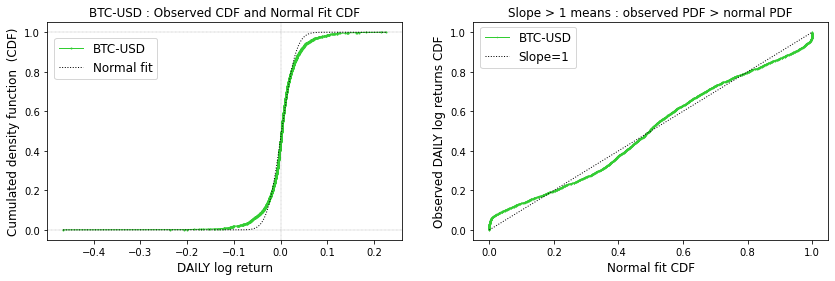

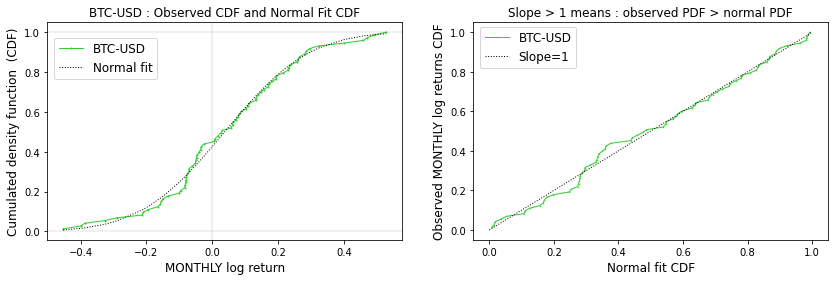

In [3]:
# selected data set for plotting
selectedCode = 'BTC-USD'

# import modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf
import pandas as pd
# select color for the data set
yahooColors = ['black','blue','#a0a0ff','salmon','limegreen','darkgreen']
code2num = { yahooCodes[num]:num for num in np.arange(len(yahooColors)) }
selectedColor = yahooColors[code2num[selectedCode]]
fontsize=12

# helper functions
def cdf(series):
    '''Calculate CDF (cumulated density function)'''
    series_dropna = series.dropna()
    series_dropna_sorted = np.sort(series_dropna)
    n = series_dropna.size
    values = np.arange(1, n + 1) / n
    return(series_dropna_sorted, values)

def func_normal_cdf(x, mu, sigma): 
    '''CDF of normal distribution with parameters mu,sigma'''
    return 0.5 * ( 1.0 + erf((x-mu)/(sigma*np.sqrt(2.0))) ) 

# plot DAILY and MONTHLY
for which_period in (["DAILY", "MONTHLY"]):
    dfsel = dict()
    if which_period == "DAILY":
        for key in df:
            dfsel[key] = df[key].copy()
    else:
        for key in dfm:
            dfsel[key] = dfm[key].copy()
            
    # Left: one selected time series as an example
    cdfx, cdfy = cdf(dfsel[selectedCode]['LogReturn']) # CDF of daily log returns
    popt, pcov = curve_fit(func_normal_cdf, cdfx, cdfy) # fit normal's CDF to observed CDF
    cdfy_fit = func_normal_cdf(cdfx, *popt) # CDF fit points
    plt.subplot(121)
    plt.xlabel(which_period + " log return", fontsize=fontsize)
    plt.ylabel("Cumulated density function  (CDF)", fontsize=fontsize)
    plt.title(selectedCode + " : Observed CDF and Normal Fit CDF", fontsize=fontsize)
    plt.plot(cdfx, cdfy, c=selectedColor, marker='o', label=selectedCode, markersize=1, lw=1)
    plt.plot(cdfx, cdfy_fit, c='k', ls=':', label='Normal fit',lw=1)
    plt.legend(bbox_to_anchor=(.02, .93), loc=2, borderaxespad=0., fontsize=fontsize)
    plt.axhline(0, c='k', ls=':', lw=.3)
    plt.axhline(1, c='k', ls=':', lw=.3)
    plt.axvline(0, c='k', ls=':', lw=.3)

    # Right panel: Plot only selected or Plot all
    plt.subplot(122)
    for code,color in zip(yahooCodes,yahooColors):
        #if True:
        if code == selectedCode: # plot the CDF-CDF only for the selected data set, use True to plot for all
            cdfx, cdfy = cdf(dfsel[code]['LogReturn']) # CDF of daily log returns
            popt, pcov = curve_fit(func_normal_cdf, cdfx, cdfy) # fit normal's CDF to observed CDF
            cdfy_fit = func_normal_cdf(cdfx, *popt) # CDF fit points
            plt.plot(cdfy_fit,cdfy,c=color, marker='.', label=code, markersize=1, lw=1)
    plt.title("Slope > 1 means : observed PDF > normal PDF", fontsize=fontsize)
    plt.xlabel("Normal fit CDF", fontsize=fontsize)
    plt.ylabel("Observed " + which_period + " log returns CDF", fontsize=fontsize)
    plt.plot([0,1],[0,1],"k:",lw=1,label="Slope=1")
    plt.legend(bbox_to_anchor=(0.02, .98), loc=2, borderaxespad=0., fontsize=fontsize)
    fig = plt.gcf()
    fig.set_size_inches([14, 4])
    plt.show()

## Log return and Abs value of log return

1. The number beside each symbol shows 1-step autocorrelation, for example, WMT (0.055). Which ticker's log return has negative autocorrelation ?
2. When we switch from log return to the abs value of log return, how does the autocorrelation change ?

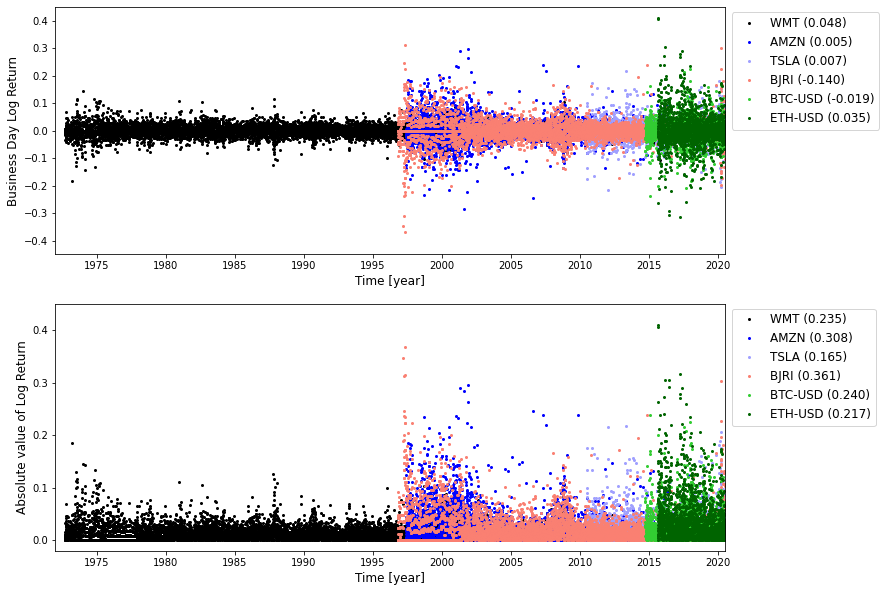

In [4]:
import matplotlib.pyplot as plt
ylims=[-.45,.45]
abs_ylims=[-.02,.45]
fontsize=12
marker='o'
markersize=2

# daily log return
plt.subplot(211)
for code,color in zip(yahooCodes,yahooColors):
    s = df[code]['LogReturn']
    autocorr = '%.3f' % s.autocorr()
    plt.plot(s, c=color, marker=marker, ms=markersize, label = code + " (" + str(autocorr) + ")", lw=0)
plt.legend(bbox_to_anchor=(1.01, .98), loc=2, borderaxespad=0., fontsize=fontsize)
plt.yscale('linear')
plt.xlabel('Time [year]', fontsize=fontsize)
plt.ylabel('Business Day Log Return', fontsize=fontsize)
plt.xlim(xlims)
plt.ylim(ylims)

# absolute value of log return
plt.subplot(212)
for code,color in zip(yahooCodes,yahooColors):
    s = np.absolute(df[code]['LogReturn'])
    autocorr = '%.3f' % s.autocorr()
    plt.plot(s, c=color, marker=marker, ms=markersize, label = code + " (" + str(autocorr) + ")", lw=0)
plt.legend(bbox_to_anchor=(1.01, .98), loc=2, borderaxespad=0., fontsize=fontsize)
plt.yscale('linear')
plt.xlabel('Time [year]', fontsize=fontsize)
plt.ylabel('Absolute value of Log Return', fontsize=fontsize)
plt.xlim(xlims)
plt.ylim(abs_ylims)

fig = plt.gcf()
fig.set_size_inches([12, 10])
plt.show()

## Autocorr of log return and abs log return

These plots show autocorrelation vs time difference. 

1. Which daily log return has significantly nonzero autocorrelation ?
2. Which abs daily log return has the highest and lowest autocorrelation after long time ?


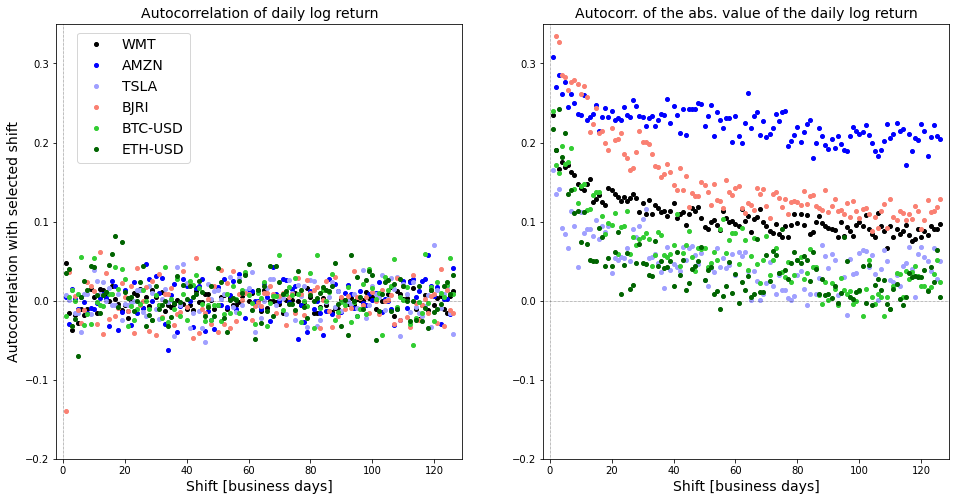

In [5]:
# main parameters
autocorr_len = 126  # check autocorrelation up to this number of business days
xmargin_of_plot = 3
autocorr_shifts = np.arange( 1 , autocorr_len + 1 )

# imports and other parameters
import matplotlib.pyplot as plt
fontsize =14
marker = 'o'
markersize = 4   
xlims = ( 1 - xmargin_of_plot, autocorr_len + xmargin_of_plot)
ylims = ( -.2, .35 )
axhline_width = 0.5

# daily log return
plt.subplot(121)
for code,color in zip(yahooCodes,yahooColors):
    s = df[code]['LogReturn']
    autocorr = [ float( '%.3f' % s.autocorr(shift) ) for shift in autocorr_shifts ]
    plt.plot(autocorr_shifts, autocorr, c=color, marker=marker, ms=markersize, label=code, lw=0)
plt.legend(bbox_to_anchor=(.05, .98), loc=2, borderaxespad=0., fontsize=fontsize)
plt.title("Autocorrelation of daily log return", fontsize=fontsize)
plt.yscale('linear')
plt.xlabel('Shift [business days]', fontsize=fontsize)
plt.ylabel('Autocorrelation with selected shift', fontsize=fontsize)
plt.axhline(0, c='k', ls=':', lw=axhline_width)
plt.axvline(0, c='k', ls=':', lw=axhline_width)
plt.xlim(xlims)
plt.ylim(ylims)

# daily log return
plt.subplot(122)
for code,color in zip(yahooCodes,yahooColors):
    s = np.absolute(df[code]['LogReturn'])
    autocorr = [ float( '%.3f' % s.autocorr(shift) ) for shift in autocorr_shifts ]
    plt.plot(autocorr_shifts, autocorr, c=color, marker=marker, ms=markersize, lw=0)
plt.title("Autocorr. of the abs. value of the daily log return", fontsize=fontsize)
plt.yscale('linear')
plt.xlabel('Shift [business days]', fontsize=fontsize)
plt.axhline(0, c='k', ls=':', lw=axhline_width)
plt.axvline(0, c='k', ls=':', lw=axhline_width)
plt.xlim(xlims)
plt.ylim(ylims)

fig = plt.gcf()
fig.set_size_inches([16, 8])
plt.show()

## Volume vs log Return

1. What do you conclude from daily log return vs traded volume plotted for each day ?
2. What do you conclude when points are binned by log return ?
3. Do your conclusions change if you select a different time window ( not 2014 - 2019 ) ?

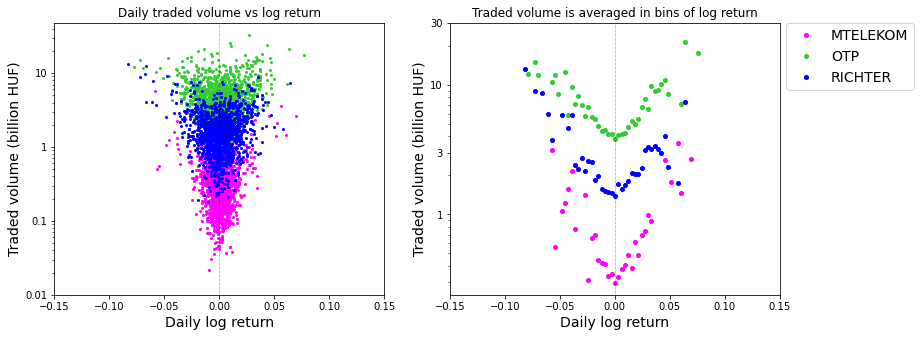

In [6]:
# the Budapest Stock Exchange (bse) time series contain trading volume
# it is assumed here that the data sets are already imported
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
bse_colors = ['magenta','limegreen','blue']
markersize=2
xmin, xmax = (-0.15, 0.15)  # note: this tuple assignment is the same as "xmin, xmax = -0.15, 0.15"
xbins = np.linspace(xmin, xmax, 100)
ytics_left = [0.01, 0.1, 1, 10]
ytics_right = [1, 3, 10, 30]
axvline_width = 0.5
marker='o'

# set index to datetime, set closing value, log return, and traded volume
for code in bse_codes:
    df[code].index = pd.to_datetime(df[code]['Date'])
    df[code]['Close'] = df[code]['Close price']
    df[code]['LogReturn'] = np.log(df[code]['Close price']) - np.log(df[code]['Close price'].shift())
    df[code]['Volume'] = df[code]['Volume (HUF value)']

# plot daily values
plt.subplot(121)
for code,color in zip(bse_codes, bse_colors):
    if True: # plot all data sets
    #if 'RICHTER' == code: # plot selected data set
        plt.plot(df[code]['LogReturn'], df[code]['Volume'] / 1e+9, 
                 c=color, marker=marker, label=code, lw=0, markersize=markersize)
plt.xlim(xmin, xmax)
plt.title("Daily traded volume vs log return")
# plt.legend(bbox_to_anchor=(.02, .02), loc=3, borderaxespad=0., fontsize=fontsize)
plt.yscale('log')
plt.xlabel('Daily log return', fontsize=fontsize)
plt.ylabel('Traded volume (billion HUF)', fontsize=fontsize)
plt.yticks(ytics_left, [str(_) for _ in ytics_left])
plt.axvline(0, c='k', ls=':', lw=axvline_width)

plt.subplot(122)
for code,color in zip(bse_codes, bse_colors):
    if True: # plot all data sets
    #if 'RICHTER' == code: # plot only this data set
        groups = df[code].groupby(pd.cut(df[code]['LogReturn'], xbins))
        plot_centers = (xbins[:-1] + xbins[1:]) / 2
        plot_values = groups['Volume'].mean() / 1e+9
        plt.plot(plot_centers, plot_values, c=color, marker=marker, label=code, lw=0, markersize=2 * markersize)
plt.xlim(xmin, xmax)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=fontsize)
plt.title("Traded volume is averaged in bins of log return")
plt.yscale('log')
plt.xlabel('Daily log return', fontsize=fontsize)
plt.ylabel('Traded volume (billion HUF)', fontsize=fontsize)
plt.yticks(ytics_right, [str(_) for _ in ytics_right])
plt.axvline(0, c='k', ls=':', lw=axvline_width)

fig = plt.gcf()
fig.set_size_inches([13, 5])
plt.show()

## Volume vs Volatility of daily close

1. Based on the below scatter plot what do you conclude for the relationship between daily log(volume) and log(volatility) ?
2. Based on the roughly even distribution of the daily points in the plot what is your chance of having a high volume day ?

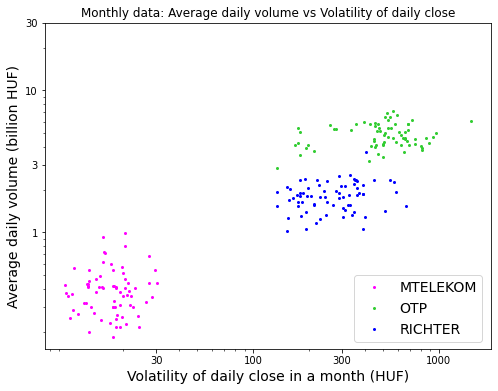

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bse_colors = ['magenta','limegreen','blue']
markersize = 2


def calculate_monthly_volatility_and_average_traded_volume(data):
    '''For each month calculate the volatility of the daily close and the average daily traded volume.'''
    monthly_data = pd.DataFrame(columns=['volatility','average_volume'])
    dates = data.index    
    yearly_dates = dates.groupby(dates.year)
    for year in yearly_dates.keys():
        monthly_dates = pd.DatetimeIndex(yearly_dates[year]).groupby(pd.DatetimeIndex(yearly_dates[year]).month)
        for month in monthly_dates.keys():
            date_all = monthly_dates[month]
            date_first = min( date_all )
            close_daily_all = [ data.loc[date]['Close'] for date in date_all ]
            volume_daily_all = [ data.loc[date]['Volume'] for date in date_all ]
            volatility = np.std( close_daily_all )
            volume_daily_average = np.average( volume_daily_all )
            monthly_data.loc[date_first] = [volatility, volume_daily_average]

    return monthly_data


# volume vs volatility
monthly_data = dict()
for code, color in zip(bse_codes, bse_colors):
    if True: # all data sets
    #if 'RICHTER' == code: # only selected data set
        monthly_data[code] = calculate_monthly_volatility_and_average_traded_volume( df[code] )
        plt.plot(monthly_data[code]['volatility'], monthly_data[code]['average_volume'] / 1e+9,
                 c=color, marker=marker, label=code, lw=0, markersize=markersize)
plt.legend(bbox_to_anchor=(.98, .02), loc=4, borderaxespad=0., fontsize=fontsize)
plt.title("Monthly data: Average daily volume vs Volatility of daily close")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Volatility of daily close in a month (HUF)', fontsize=fontsize)
plt.ylabel('Average daily volume (billion HUF)', fontsize=fontsize)
plt.xticks([30, 100, 300, 1000],['30','100','300','1000'])
plt.yticks([1, 3, 10, 30],['1','3','10','30'])

fig = plt.gcf()
fig.set_size_inches([8, 6])
plt.show()



## Skewness of log returns distribution 

1. What does the sum of the highest and the lowest value tell about a distribution ?
2. Does the negative skew of SP500 mean that stock prices respond faster to negative news than to positive news ?

| Name | Symbol and Calculation |
|:-----|:------------|
| Random variable | $X$ |
| Mean | $\mu = E\left[ \,X \,\right]$ |
| Variance | ${\displaystyle \sigma^{\,2} = E\left[ \, \left( \, X - \mu \, \right)^{\,2} \, \right] }$ |
| Volatility = Std.dev. | $\sigma$ |
| Skewness | ${\displaystyle E\left[\,\left(\frac{X-\mu}{\sigma}\,\right)^{\,3} \, \right]}$|

Skew	Name	Long Name of Data Set
+0.90	AAA10Y	AAA10Y
-0.06	GOLD	GOLDPMGBD228NLBM
-0.42	JPYUSD	DEXJPUS
-0.88	US1YSW	ICERATES1100USD1Y
-1.19	S&P500	SP500
-0.44	WILLSH	WILLRESIPR


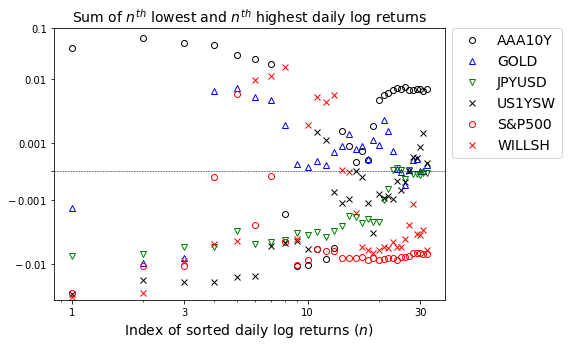

In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import matplotlib.pyplot as plt
FONTSIZE = 14

# select data sets to be analyzed, set their display names, set colors for plotting them
fred_selected_codes = {'AAA10Y':'AAA10Y', 'GOLDPMGBD228NLBM':'GOLD', 'DEXJPUS':'JPYUSD', 
    'ICERATES1100USD1Y': 'US1YSW', 'SP500': 'S&P500', 'WILLRESIPR':'WILLSH'}
fred_colors = ['black','blue','green','black','red','red']
fred_markers = ['o','^','v','x','o','x']
fred_fill = ['none','none','none','none','none','none']
axhline_width = 0.5 
markersize = 6
markeredgewidth = 1
display_len = 32 # display this number of points
linthreshy = 0.002 # threshold for the simlog y scaling


# read fred data sets again without the . lines, calculate log return
for code in fred_selected_codes:
    df[code] = pd.read_csv(data_dir + os.sep + code + "." + file_ext, na_values='.')
    df[code]['LogReturn'] = np.log(df[code][code]) - np.log(df[code][code]).shift()


# write skewness and plot differences
print("Skew\tName\tLong Name of Data Set")
for code, color, marker, fill in zip(fred_selected_codes, fred_colors, fred_markers, fred_fill):
    if True: # plot all data
    #if code.startswith('AA'): # plot selected
        log_returns = df[code]['LogReturn']
        log_returns_num = log_returns[ (log_returns>-1e+6) & (log_returns<1e+6) ] # select numbers
        sorted_log_returns = pd.Series.sort_values( log_returns_num ).tolist() # sort into ascending order
        sum_reversed = np.add( sorted_log_returns, sorted_log_returns[::-1] ) # add list to itself reversed
        sum_reversed = sum_reversed[:display_len:] # keep only the requested number of items from the start
        display_name = fred_selected_codes[code]
        print("%+.2f\t%s\t%s" % (stats.skew(sorted_log_returns), display_name, code))
        is_first = False
        plt.plot(1 + np.arange(len(sum_reversed)) , sum_reversed,
                 c=color, marker=marker, label=display_name, lw=0, fillstyle=fill, 
                 markersize=markersize, markeredgewidth=markeredgewidth)
plt.title('Sum of $n^{th}$ lowest and $n^{th}$ highest daily log returns', fontsize=FONTSIZE)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=FONTSIZE)
plt.xscale('log')
plt.yscale('symlog', linthreshy=linthreshy)
plt.xlabel('Index of sorted daily log returns ($n$)', fontsize=FONTSIZE)
plt.xticks([1,3,10,30],['1','3','10','30'])
plt.yticks([-0.01,-0.001,0,0.001,0.01,0.1],['$-\,0.01$','$-\,0.001$','','0.001','0.01','0.1'])
plt.axhline(0, c='k', ls='--', lw=axhline_width)

fig = plt.gcf()
fig.set_size_inches([7, 5])
plt.show()

## Task: yearly mean of daily log returns and yearly volatility
For each year separately, calculate (1) the mean of the daily log return of WMT, and (2) the volatility of the daily log returns of WMT.

###### Answer

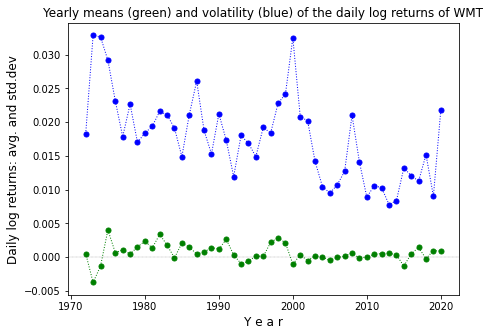

'Yearly mean of daily log returns in sorted order'

Year
1973   -0.003760
1974   -0.001352
2015   -0.001338
2000   -0.001045
1993   -0.000976
1994   -0.000645
2002   -0.000518
2005   -0.000480
2018   -0.000233
2009   -0.000189
1984   -0.000116
2006   -0.000053
2004   -0.000017
2010    0.000035
1996    0.000087
2007    0.000115
1995    0.000182
2003    0.000195
2001    0.000323
1992    0.000329
2014    0.000347
2011    0.000407
1987    0.000442
1978    0.000462
2016    0.000476
1972    0.000523
2012    0.000530
2013    0.000566
2008    0.000652
1976    0.000657
1988    0.000743
2020    0.000890
2019    0.000967
1977    0.001061
1990    0.001181
1981    0.001344
1989    0.001420
2017    0.001421
1986    0.001493
1979    0.001500
1983    0.001768
1985    0.002066
1999    0.002100
1997    0.002175
1980    0.002366
1991    0.002632
1998    0.002877
1982    0.003372
1975    0.004017
Name: LogReturnDaily, dtype: float64

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
FONTSIZE = 12

# data processing
df = pd.read_csv(os.path.join('data', 'WMT.csv'))
df['Year'] = pd.to_datetime(df.Date).dt.year
df['LogReturnDaily'] = np.log(df['Close']) - np.log(df['Close'].shift())
daily_log_ret_yearly_mean = df.groupby(df.Year).LogReturnDaily.agg('mean')
daily_log_ret_vol = df.groupby(df.Year).LogReturnDaily.agg('std')

# plotting
fig, axes = plt.subplots(figsize=(7, 5))
plt.plot(daily_log_ret_yearly_mean, markersize=10, marker='.', linestyle=':', linewidth=1, color='g')
plt.plot(daily_log_ret_vol, markersize=10, marker='.', linestyle=':', linewidth=1, color='b')
plt.title('Yearly means (green) and volatility (blue) of the daily log returns of WMT', fontsize=FONTSIZE)
plt.xlabel('Y e a r', fontsize=FONTSIZE)
plt.ylabel('Daily log returns: avg. and std.dev', fontsize=FONTSIZE)
plt.axhline(0, c='k', ls=':', lw=.3)
plt.show()

# investigate the average returns in sorted order
daily_log_ret_yearly_mean.sort_values(inplace=True)
display('Yearly mean of daily log returns in sorted order', daily_log_ret_yearly_mean)